# Exercício de Transfer Learning - Marco Aurélio Garcia

O presente notebook tem o objetivo de resolver o desafio final do curso de Machine Learning. O notebook segue o exemplo de notebook de referência compartilhado na página do desafio (https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb#scrollTo=CIqHecNAYoaj).

Aqui listo alguns desafios ao realizar o exercício:

1 - Instalação do TensorFlow na minha máquina local considerando as versões adequadas dos pacotes para utilização da GPU.

2 - Execução do Notebook no Jupyter Colab não funcionou por tentativa de consumo de recursos indisponíveis. Decidi concluir o desafio na minha máquina.

Em alto nível o processo deste notebook pode ser descrito conforme abaixo:

## 1 - Coleta das imagens para classificação 
Obtenção do dataset Cats & Dogs - https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

## 2 - Tratamento das imagens para utilização com o TensorFlow
As imagens passam por preprocessamento e preparação para serem utilizadas ao longo do processo e uso com o TensorFlow.

## 3 - Criação de uma rede neural para classificação das imagens com ajuda do ChatGPT
Foi criada uma rede neural com ajuda do ChatGPT, o modelo foi alterado para ajustar os shapes dos objetos, assim como para utilizar a função softmax.

## 4 - Utilização da rede neural preexistente no jupyter colab de referência
No notebook de referência existe uma rede neural. Utilizei esta referência para comparar com a rede criada pelo ChatGPT.

## 5 - Utilização de uma rede neural preexistente através de transfered learning
Assim como no notebook de referência, foi utilizada a rede VGG16 para comparação com as redes anteriores. Para tanto foi utilizado o método de transfer learning.

## 6 - Comparar o resultado das três redes
Para cada uma das redes são analisadas as métricas de loss e acuracy.


In [1]:
# Importação dos objetos e bibliotecas necessárias

%matplotlib inline

import os

import random
import numpy as np
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model


### 1 - Coleta das imagens para classificação

Download do dataset e descompactação do pacote. 

In [2]:
!echo "Realizando o download do dataset Cats & Dogs"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
!tar -xf kagglecatsanddogs_5340.zip
# !rm kagglecatsanddogs_5340.zip  #Para excluir arquivos em ambiente Linux ou Jupyter Colab
!del kagglecatsanddogs_5340.zip #Para excluir arquivos em ambiente Windows


"Realizando o download do dataset Cats & Dogs"



#=#=#                                                                          
                                                                           0.0%
                                                                           0.1%
                                                                           0.2%
                                                                           0.4%
                                                                           0.6%
                                                                           0.8%
                                                                           1.0%
                                                                           1.3%
#                                                                          1.5%
#                                                                          1.8%
#                                                                          2.1%
#                                      

In [10]:
root = '.\\PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['.\\PetImages\\Cat', '.\\PetImages\\Dog']


### 2 - Tratamento das imagens para utilização com o TensorFlow

Carga das imagens, conversão para formatos adequados, organização dos conjuntos e conversão para tensores

In [11]:
# Função que deve ser utilizada para carregar as imagens e preprocessa-las devolvendo também seu input vector, que é a representação numérica da 
# imagem e que será utilizada para o tensorflow
def get_image(path):
    img = load_img(path, target_size=(224, 224)) 
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [12]:
# Carrega as imagens dos tipos '.jpg','.png','.jpeg' disponíveis nos diretórios ['.\\PetImages\\Cat', '.\\PetImages\\Dog']
# Cria uma lista de dicionários cujas chaves identificam os input vectors como x e as categorias (cat or dog) como y
# Este procedimento foi reutilizado do notebook de exemplo, sendo ajustado para considerar exceções no carregamento das imagens.

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except Exception as err:
            print("Falha ao carregar o arquivo " + img_path )
        

# count the number of classes
num_classes = len(categories)
print("Quantidade de classes encontradas: ", num_classes)

Falha ao carregar o arquivo .\PetImages\Cat\666.jpg
Falha ao carregar o arquivo .\PetImages\Dog\11702.jpg


C:\Users\mavga\anaconda3\envs\TensorFlowBase\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Quantidade de classes encontradas:  2


In [13]:
# Randomiza as imagens e cria as divisões de treinamento, validação e testes (70%, 15%, 15%)

random.shuffle(data)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [14]:
# Separa os dados das por rótulos x (variáveis independentes) e y (variável dependente) filtrando pelas chaves do dicionário

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 

In [15]:
# Realiza o pre-processamento dos datasets, convertendo os tipos de dados para float 32 e normalizando os valores

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Converte os conjuntos y para matrizes de classe binária para processamento no tensorflow
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_test.shape: ", y_test.shape)

# Converte os conjuntos em tensores
with tf.device('/CPU:0'):
    x_train_tensor = tf.convert_to_tensor(x_train, np.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, np.float32)
    x_test_tensor = tf.convert_to_tensor(x_test, np.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, np.float32)
    x_val_tensor = tf.convert_to_tensor(x_val, np.float32)
    y_val_tensor = tf.convert_to_tensor(y_val, np.float32)

y_test.shape:  (3750, 2)


In [16]:
# Sumário dos dados que trabalhamos:
print("Foram Carregadas %d imagens pertencentes a %d categorias"%(len(data), num_classes))
print("Conjuntos de treinamento / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Formato dos dados de trainamento (Variáveis independentes): ", x_train.shape)
print("Formato do conjunto y (Variável dependentes): ", y_train.shape)


Foram Carregadas 24998 imagens pertencentes a 2 categorias
Conjuntos de treinamento / validação / teste: 17498, 3750, 3750
Formato dos dados de trainamento (Variáveis independentes):  (17498, 224, 224, 3)
Formato do conjunto y (Variável dependentes):  (17498, 2)


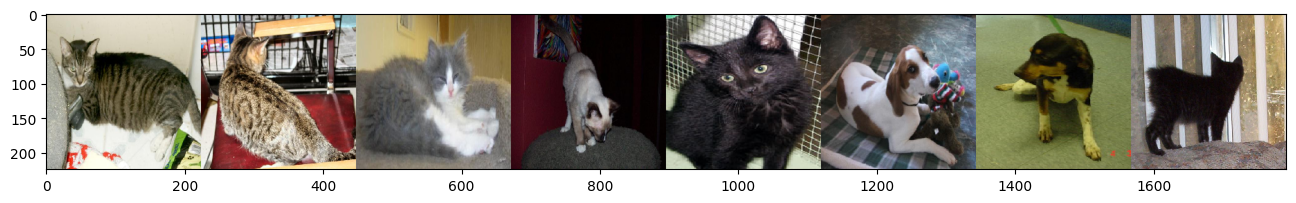

In [13]:
# Algumas imagens carregads por exemplo

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### 3 - Criação de uma rede neural para classificação das imagens com ajuda do ChatGPT

A seguinte rede neural foi criada com ajuda do chat GPT com o seguinte prompt:
Gostaria que você gerasse uma rede neural usando tensor flow e keras para classificar imagens que pertencem a duas categorias.
O atributo input_shape da camada de entrada foi ajustado para ficar dinâmico conforme shape do x_train. A última camada foi ajustada para considerar a variável num_classes assim como a função de ativação foi modificada para softmax.



In [38]:
# Construção do modelo

print("Input dimensions: ",x_train.shape[1:])
print("Number of classes: ",num_classes)

model_gpt = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Saída binária
])
model_gpt.summary()


Input dimensions:  (224, 224, 3)
Number of classes:  2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 

In [39]:
# Compilação do modelo
model_gpt.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [40]:
# Treinamento
history_gpt = model_gpt.fit(x_train_tensor, y_train_tensor,
                            batch_size=32,
                            epochs=10,
                            validation_data=(x_val_tensor, y_val_tensor))

Epoch 1/10
547/547 [==============================] - 44s 62ms/step - loss: 0.6101 - accuracy: 0.6743 - val_loss: 0.5287 - val_accuracy: 0.7389
Epoch 2/10
547/547 [==============================] - 33s 61ms/step - loss: 0.4600 - accuracy: 0.7814 - val_loss: 0.4928 - val_accuracy: 0.7632
Epoch 3/10
547/547 [==============================] - 33s 61ms/step - loss: 0.3572 - accuracy: 0.8429 - val_loss: 0.4328 - val_accuracy: 0.8045
Epoch 4/10
547/547 [==============================] - 33s 61ms/step - loss: 0.2187 - accuracy: 0.9110 - val_loss: 0.5307 - val_accuracy: 0.8117
Epoch 5/10
547/547 [==============================] - 33s 61ms/step - loss: 0.0827 - accuracy: 0.9723 - val_loss: 0.7150 - val_accuracy: 0.7963
Epoch 6/10
547/547 [==============================] - 33s 61ms/step - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.9488 - val_accuracy: 0.7856
Epoch 7/10
547/547 [==============================] - 33s 61ms/step - loss: 0.0294 - accuracy: 0.9903 - val_loss: 1.0371 - val_accuracy:

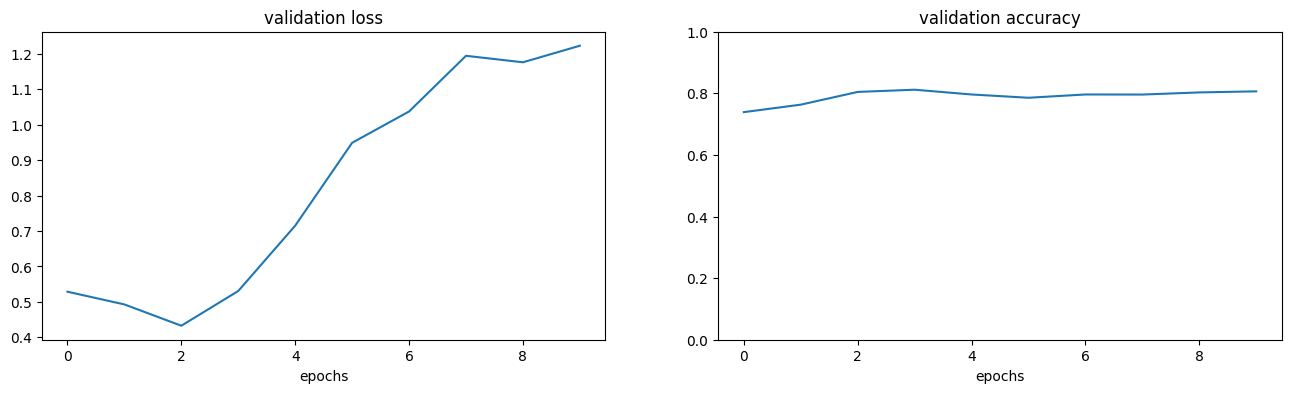

In [41]:
# Analisando as métricas de validação

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history_gpt.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history_gpt.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

### 4 - Utilização da rede neural preexistente no jupyter colab de referência

A rede utilizada abaixo é o mesmo código compartilhado no jupyter colab conforme a Introdução deste notebook, com descrição conforme abaixo:

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [42]:
# Construção do modelo
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

In [43]:
# Compilando o modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Treinando o modelo
history = model.fit(x_train_tensor, y_train_tensor,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val_tensor, y_val_tensor))


Epoch 1/10
547/547 [==============================] - 23s 41ms/step - loss: 0.6013 - accuracy: 0.6623 - val_loss: 0.5563 - val_accuracy: 0.7168
Epoch 2/10
547/547 [==============================] - 22s 40ms/step - loss: 0.4938 - accuracy: 0.7648 - val_loss: 0.4292 - val_accuracy: 0.8077
Epoch 3/10
547/547 [==============================] - 22s 39ms/step - loss: 0.4128 - accuracy: 0.8111 - val_loss: 0.3869 - val_accuracy: 0.8248
Epoch 4/10
547/547 [==============================] - 21s 39ms/step - loss: 0.3584 - accuracy: 0.8428 - val_loss: 0.3737 - val_accuracy: 0.8392
Epoch 5/10
547/547 [==============================] - 21s 39ms/step - loss: 0.3161 - accuracy: 0.8619 - val_loss: 0.3873 - val_accuracy: 0.8397
Epoch 6/10
547/547 [==============================] - 22s 40ms/step - loss: 0.2850 - accuracy: 0.8770 - val_loss: 0.3201 - val_accuracy: 0.8693
Epoch 7/10
547/547 [==============================] - 22s 39ms/step - loss: 0.2563 - accuracy: 0.8924 - val_loss: 0.3215 - val_accuracy:

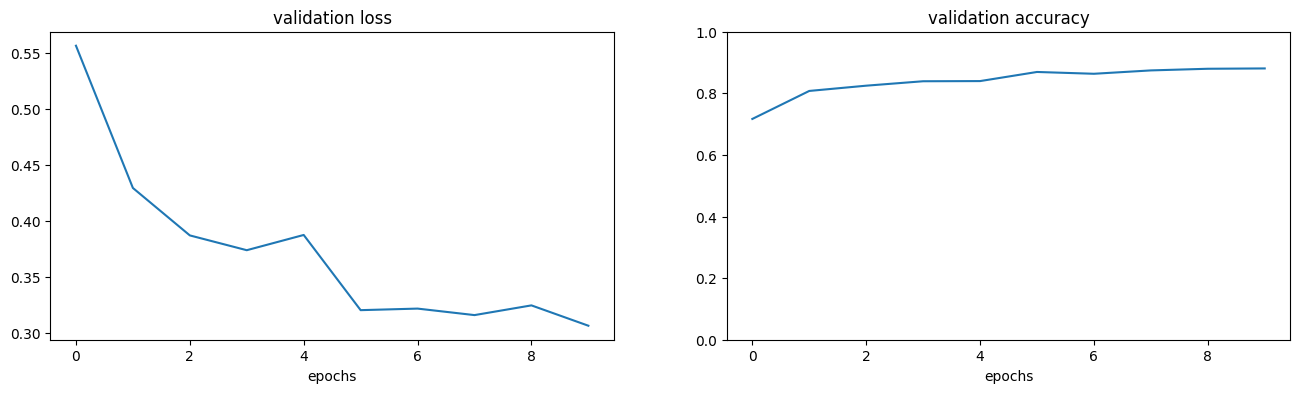

In [44]:
# Analisando as métricas de validação

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

## 5 - Utilização de uma rede neural preexistente através de transfered learning

Agora podemos fazer o experimento de utilização de um modelo que já foi treinado com um conjunto de imagens. Vamos utilizar a VGG16, que conforme descrição online, trata-se de uma rede neural convolucional (CNN), utilizada em problemas de visão computacional para classificação de imagens. O modelo foi desenvolvido pelo Visual Geometry Group (VGG) da Universidade de Oxford.

In [45]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
# Criação da nova rede reutilizando a VGG16

# Obtem a referência à camada de input da rede VGG16
inp = vgg.input

# cria uma nova camada softmax com a quantidade de classes parametrisada (duas no nosso caso)
new_classification_layer = Dense(num_classes, activation='softmax')

# Conecta a recen criada new_classification_layer à penúltima camada da VGG16, salvando em "out" as camadas resultantes
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede com inp e out
model_new = Model(inp, out)


Conforme descrição do notebook original, após reestruturação das camadas originais do VGG16 conforme necessidades do nosso exercício, o próximo passo é congelar os pesos previamente calculados das camadas intermediárias, treinando apenas a camada recém criada:

We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [47]:
# Configura as camadas da nova rede para não serem treinadas (a não ser a última), congelando assim os pesos calculados no momento de criação da rede.
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Garante que a última camada será treinada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# Compila o modelo
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
# Treinando o modelo com os datasets de gatos e cães
history2 = model_new.fit(x_train_tensor, y_train_tensor,
                         batch_size=16,
                         epochs=10,
                         validation_data=(x_val_tensor, y_val_tensor))


Epoch 1/10
1094/1094 [==============================] - 78s 68ms/step - loss: 0.2779 - accuracy: 0.8790 - val_loss: 0.2443 - val_accuracy: 0.8984
Epoch 2/10
1094/1094 [==============================] - 71s 65ms/step - loss: 0.2234 - accuracy: 0.9060 - val_loss: 0.2397 - val_accuracy: 0.8992
Epoch 3/10
1094/1094 [==============================] - 71s 65ms/step - loss: 0.2142 - accuracy: 0.9108 - val_loss: 0.2080 - val_accuracy: 0.9160
Epoch 4/10
1094/1094 [==============================] - 71s 65ms/step - loss: 0.2044 - accuracy: 0.9127 - val_loss: 0.1839 - val_accuracy: 0.9256
Epoch 5/10
1094/1094 [==============================] - 71s 65ms/step - loss: 0.1984 - accuracy: 0.9190 - val_loss: 0.2022 - val_accuracy: 0.9205
Epoch 6/10
1094/1094 [==============================] - 71s 65ms/step - loss: 0.1973 - accuracy: 0.9189 - val_loss: 0.1789 - val_accuracy: 0.9275
Epoch 7/10
1094/1094 [==============================] - 600s 549ms/step - loss: 0.1890 - accuracy: 0.9225 - val_loss: 0.1840

## 6 - Comparar o resultado das três redes

Listo abaixo os gráficos de linha que apresentam perda e acurácia ao longo das 10 épocas de treinamento dos modelos supracitados.

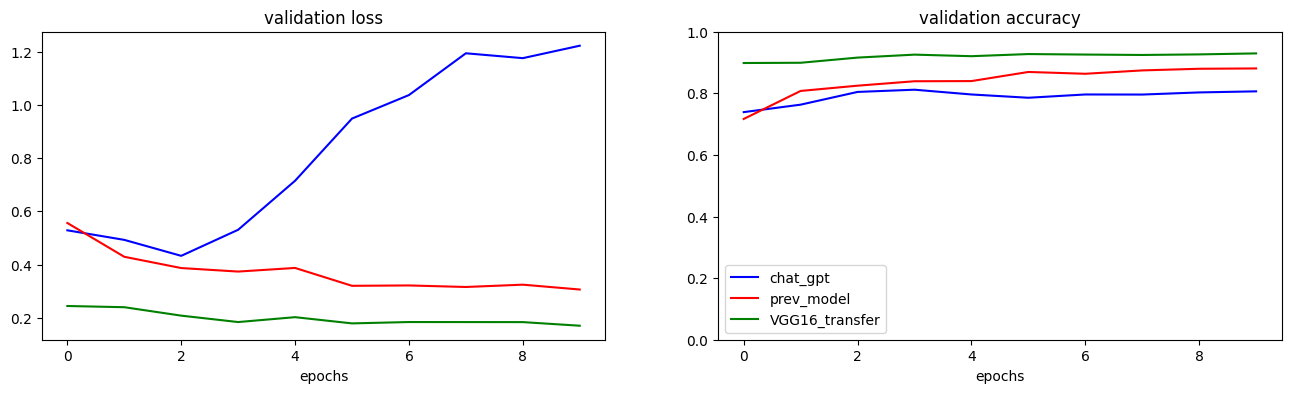

In [56]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)

ax.plot(history_gpt.history["val_loss"], "-b", label="chat_gpt")
ax.plot(history.history["val_loss"], "-r", label="prev_model")
ax.plot(history2.history["val_loss"], "-g", label="VGG16_transfer")
ax.set_title("validation loss")
ax.set_xlabel("epochs")


ax2 = fig.add_subplot(122)
ax2.plot(history_gpt.history["val_accuracy"], "-b", label="chat_gpt")
ax2.plot(history.history["val_accuracy"], "-r", label="prev_model")
ax2.plot(history2.history["val_accuracy"], "-g", label="VGG16_transfer")
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
plt.legend()
plt.show()

É possível ver nestes gráficos o quanto a rede VGG16 alcança maior acurácia do que as duas outras, assim como menor perda. A rede neural presente do Jupyter Colab de referência apesar de apresentar métricas piores do que a VGG16, teve comportamente semelhante à VGG16 ao longo do treinamento, aumentando acurácia e reduzindo perda enquanto que a rede neural criada pelo pelo ChatGPT começou a aumentar a partir da segunda era enquanto que a acurácia permaneceu estável, indicando a necessidade de revisão do modelo sugerido pelo ChatGPT.
Segue abaixo o uso das três redes para previsão conjunto de testes.

In [ ]:
loss, accuracy =  model_gpt.evaluate(x_test_tensor, y_test_tensor, verbose=0)

print('Perda no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

In [ ]:
loss, accuracy =  model.evaluate(x_test_tensor, y_test_tensor, verbose=0)

print('Perda no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

In [87]:
loss, accuracy = model_new.evaluate(x_test_tensor, y_test_tensor, verbose=0)

print('Perda no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

Test loss: 0.17309291660785675
Test accuracy: 0.9317333102226257
